**Цель данного проекта:** анализ сервиса аренды самокатов GoFast. В нашем распоряжении есть данные о некоторых пользователях из нескольких городов, а также об их поездках. В этой работе предстоит проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. В частности, необходимо оценить поведение пользователей с подпиской и без подписки, выяснить, кто из них приносит больше выручки, и разработать стратегии для увеличения числа подписчиков.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки:**
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;  
**с подпиской Ultra:**
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

<div class="alert alert-block alert-warning">📝
    
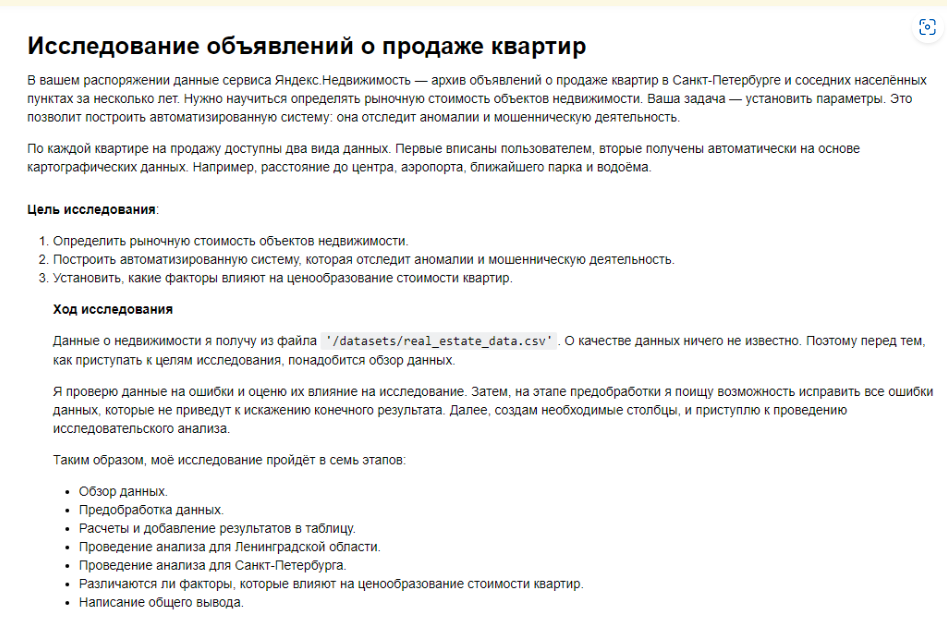
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv') # таблица пользователей
rides = pd.read_csv('/datasets/rides_go.csv') #  таблица поездок
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv') # таблица подписок

Датасет **users** содержит информацию о пользователях сервиса, всего в выборку попало 1565 пользователей. Нулевые значения отсутствуют, типы данных корректны. Данные включают пять столбцов:

user_id: уникальный идентификатор пользователя (int64)  
name: имя пользователя (object)  
age: возраст пользователя (int64)  
city: город пользователя (object)  
subscription_type: тип подписки пользователя (object), значения могут быть "free" (без подписки) или "ultra" (с подпиской)

In [3]:
display(users.head())
print(users.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


Датасет **rides** содержит данные о поездках пользователей сервиса. Всего в датафрейме содержится 18068 записей (поездок). Пропущенные значения отсутствуют, типы данных корректны кроме столбца date - на шаге предобработки данных мы измениим его на datetime64. Всего датасет содержит 4 столбца:

user_id: уникальный идентификатор пользователя (int64)  
distance: пройденное расстояние в метрах (float64)  
duration: продолжительность поездки в минутах (float64)  
date: дата поездки (object)

In [4]:
display(rides.head())
print(rides.info())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


Датасет **subscriptions** содержит информацию о типах подписки. Всего в датафрейме содержится 2 записи (по одной на каждый тип подписки). Пропущенные значения отсутствуют, типы данных корректны. Датафрейм содержит следующие столбцы:

subscription_type: тип подписки (object), возможные значения - "free" и "ultra"  
minute_price: стоимость одной минуты поездки по данной подписке (int64)  
start_ride_price: стоимость начала поездки по данной подписке (int64)  
subscription_fee: стоимость ежемесячной подписки (int64)

In [5]:
display(subscriptions.head())
print(subscriptions.info())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


### Шаг 2. Предобработка данных

In [6]:
# функция, которая проверяет датасет на наличие явных дубликатов и нулевых значений

def preprocess(df):

    # проверка и удаление явных дубликатов
    if df.duplicated().sum() > 0:
        print(f"Найдено {df.duplicated().sum()} дубликатов. Они будут удалены.")
        df = df.drop_duplicates()
    else:
        print("Явные дубликаты отсутствуют.")
        
    # проверка и вывод строк с нулевыми значениями
    null_rows = df[df.isnull().any(axis=1)]
    if not null_rows.empty:
        print(f"Найдено {len(null_rows)} строк с нулевыми значениями. Выведем их.")
        print(null_rows)
    else: 
         print("Нулевые значения отсутствуют.")
    
    return df

Будем работать с каждым датасетом отдельно. 

#### **Датасет Users:**

In [7]:
preprocess(users)

Найдено 31 дубликатов. Они будут удалены.
Нулевые значения отсутствуют.


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


In [8]:
users = users.drop_duplicates()
users.duplicated().sum()

0

#### **Датасет Rides:**

In [9]:
preprocess(rides)

Явные дубликаты отсутствуют.
Нулевые значения отсутствуют.


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


Проверим за какой период представлены данные о поездках.

In [10]:
min_date = rides['date'].min()
max_date = rides['date'].max()

print(f"Данные о поездках доступны за период с {min_date} по {max_date}.")

Данные о поездках доступны за период с 2021-01-01 по 2021-12-30.


Изменим тип столбца с датой на верный и добавим столбец с месяцем поездки.

In [11]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = rides['date'].dt.month

Проверим столбец длительности на предмет наличия аномалий.

In [12]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Аномалий не наблюдается. В среднем поездка длится чуть больше 17 минут, медиана и среднее практически совпадают. Минимальная длительность - полминуты, такое может быть, если пользователь начал поездку по ошибке/передумал и отменил ее; максимальная длительность - 40 минут, что тоже в пределах нормы.

In [13]:
display(rides.info())
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


None

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### **Датасет Subscriptions:**

In [14]:
preprocess(subscriptions)

Явные дубликаты отсутствуют.
Нулевые значения отсутствуют.


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Микровывод

На этом шаге данные подверглись предобработке. Качество исходных данных высокое: нулевых значений нет ни в одном датасете, явные дубликаты оказались только в датасете с пользователями users - и были удалены. Также на этом шаге был преобразован строковый тип данных столбца date датасета rides на правильный тип даты, а также добавлен столбец с месяцем поездки. Выяснилось, что выборка данных представлена периодом с января по декабрь 2021 года. Аномалий в данных выявлено не было, они готовы к анализу. 

### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

#### Частота встречаемости городов

In [15]:
users_by_city = users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id')
users_by_city

,user_id
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


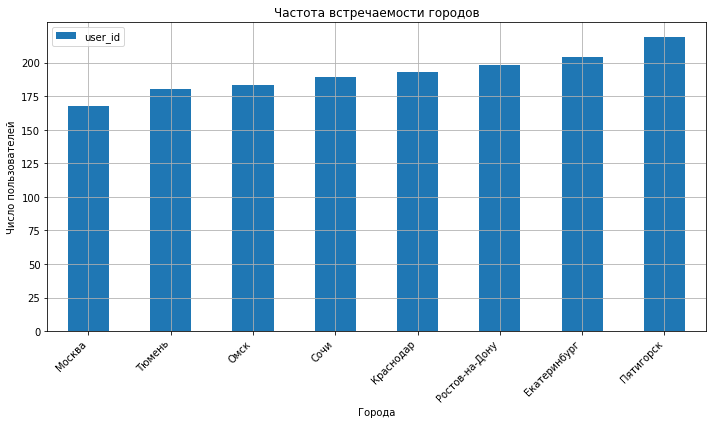

In [16]:
users_by_city.plot(kind='bar', figsize=(10, 6), grid=True)

plt.yticks(ticks=range(0, int(users_by_city.max()) + 1, 25))
plt.xticks(rotation=45, ha='right')
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Число пользователей')

plt.tight_layout()
plt.show()

Большинство пользователей находится в Пятигорске, а вот меньше всего в выборке оказалось самокатчиков-москвичей; однако стоит отметить, что разница в количестве пользователей во всех городах не слишком велика.

#### Соотношение пользователей с подпиской и без подписки

In [17]:
users_by_sub = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').sort_values(by='user_id')
users_by_sub

,user_id
subscription_type,
ultra,699
free,835


<Figure size 864x864 with 0 Axes>

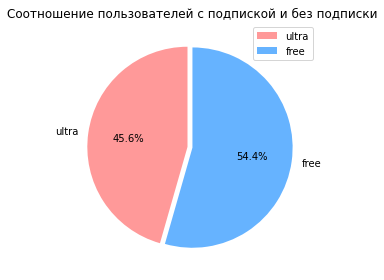

In [18]:
plt.figure(figsize=(12, 12))
users_by_sub.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.05, 0), subplots=True)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.tight_layout()
plt.show()

Большинство пользователей не приобретают подписку. 

#### Возраст пользователей

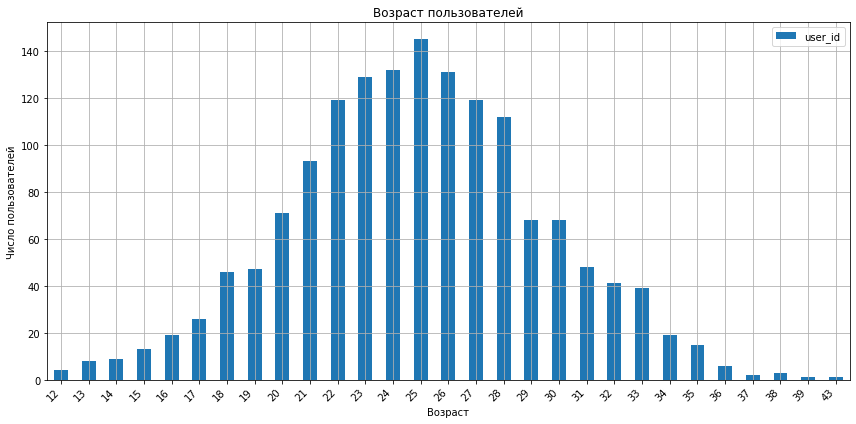

In [19]:
users_by_age = users.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age')
users_by_age.plot(kind='bar', figsize=(12, 6), grid=True)

plt.xticks(rotation=45, ha='right')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')

plt.tight_layout()
plt.show()

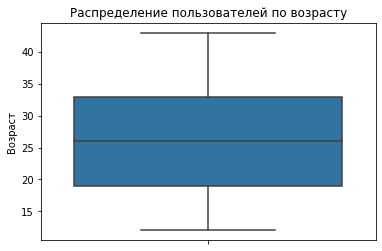

In [20]:
# преобразование Series в DataFrame для корректной передачи данных в боксплот 

users_by_age_df = users_by_age.reset_index()
users_by_age_df.columns = ['age', 'count']

sns.boxplot(y=users_by_age_df['age'])
plt.title('Распределение пользователей по возрасту')
plt.ylabel('Возраст')
plt.show()

Распределение больше всего походит на нормальное. Поскольку в большинстве случаев выборочное среднее предоставляет достаточно точную оценку среднего генеральной совокупности, можно сказать, что самый часто встречаемый возраст пользователей сервиса - окло 25 лет. 

#### Расстояние, которое пользователь преодолел за одну поездку

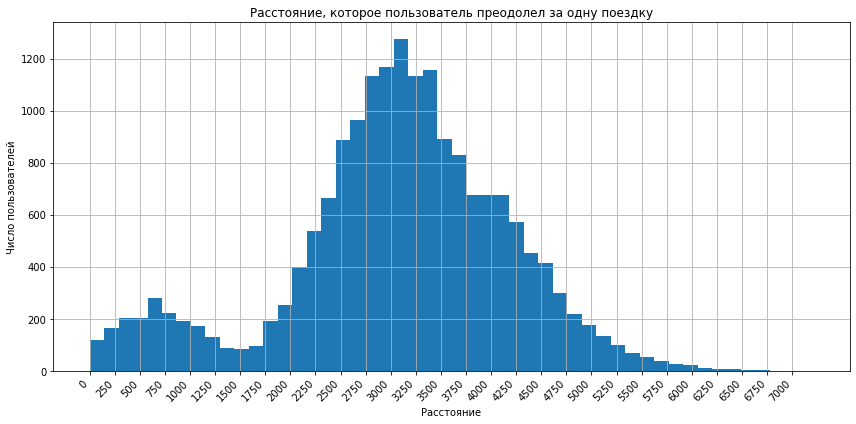

In [21]:
rides['distance'].hist(figsize=(12, 6), bins=50, grid=True)

plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=range(0, int(rides['distance'].max()) + 1, 250))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Число пользователей')

plt.tight_layout()
plt.show()

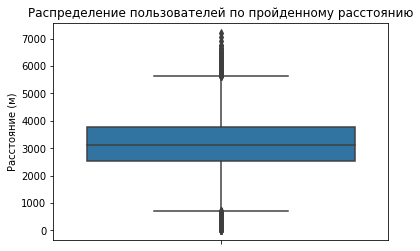

In [22]:
sns.boxplot(y=rides['distance'])
plt.title('Распределение пользователей по пройденному расстоянию')
plt.ylabel('Расстояние (м)')
plt.show()

Чаще всего пользователи проезжали около 3-3.5 км за поездку. Небольшой пик наблюдается в районе 0.5-1 км, можно сделать предположение, что в этих случаях пользователи арендовали самокат, чтобы быстро преодолеть небольшое расстояние: например от метро/автобусной остановки до дома. 

#### Продолжительность поездок

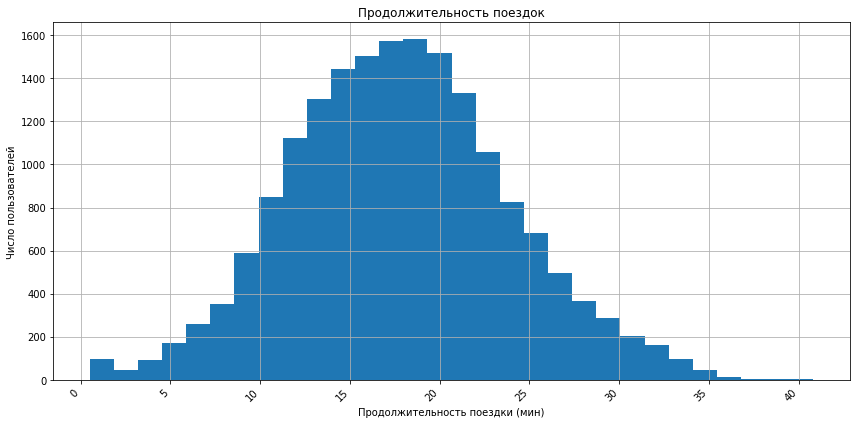

In [23]:
rides['duration'].hist(figsize=(12, 6), bins=30, grid=True)

plt.xticks(rotation=45, ha='right')
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездки (мин)')
plt.ylabel('Число пользователей')

plt.tight_layout()
plt.show()

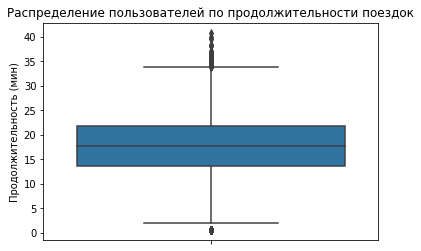

In [24]:
# преобразование Series в DataFrame для корректной передачи данных в боксплот 

sns.boxplot(y=rides['duration'])
plt.title('Распределение пользователей по продолжительности поездок')
plt.ylabel('Продолжительность (мин)')
plt.show()

Распределение похоже на нормальное. Среднее время поездки - 17-18 минут, примерно за это время на самокате как раз преодолевается 3-3.5 км. 

#### Микровывод 

Портрет типичного пользователя сервиса - это человек 24-26 лет без подписки, использующий самокат для преодоления небольших расстояний в районе 3 км. 

### Шаг 4. Объединение данных

In [25]:
# размер датасетов до объединения

print("Размерность users:", users.shape)
print("Размерность rides:", rides.shape)
print("Размерность subscriptions:", subscriptions.shape)

Размерность users: (1534, 5)
Размерность rides: (18068, 5)
Размерность subscriptions: (2, 4)


####  Объединение данных о пользователях, поездках и подписках 

In [26]:
# объединение датасетов и их размерность после объединения

user_rides = pd.merge(users, rides, on='user_id')
print("Размерность user_rides после объединения:", user_rides.shape)

full_data = pd.merge(user_rides, subscriptions, on='subscription_type')
print("Размерность full_data после объединения:", full_data.shape)

full_data.head()

Размерность user_rides после объединения: (18068, 9)
Размерность full_data после объединения: (18068, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Размерность нового датасета верна.

#### Пользователи с подпиской и без подписки

In [27]:
no_subscription = full_data[full_data['subscription_type'] == 'free']
with_subscription = full_data[full_data['subscription_type'] == 'ultra']

display(no_subscription.head())
display(with_subscription.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [28]:
print(no_subscription.info())
print(with_subscription.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFr

Судя по количеству строк в обоих датасетах, можно предположить, что пользователи без подписки совершают в два раза больше поездок по сравнению с пользователями с подпиской. При сравнении количества пользователей с и без подписок в датасете users разница была лишь около 100 человек, чего не скажешь о существенной разнице в количестве поездок этих двух категорий. 

#### Визуализация пройденного расстояния для обоих категорий

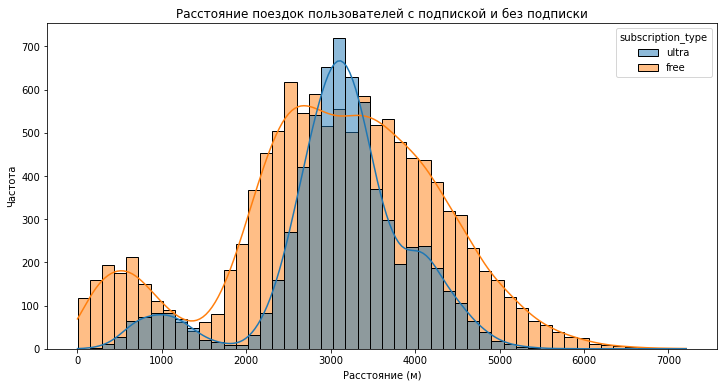

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(data=full_data, x='distance', hue='subscription_type', bins=50, kde=True)
plt.title('Расстояние поездок пользователей с подпиской и без подписки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.show()

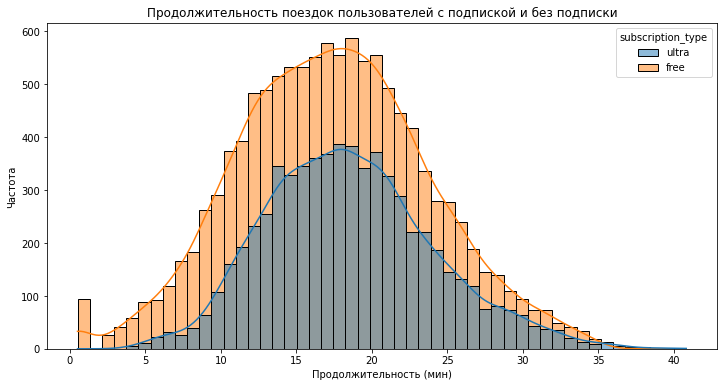

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(data=full_data, x='duration', hue='subscription_type', bins=50, kde=True)
plt.title('Продолжительность поездок пользователей с подпиской и без подписки')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
plt.show()

#### Микровывод

Пользователи **без подписки** совершают более разнообразные поездки по расстоянию и продолжительности, включая значительное количество более длинных и продолжительных поездок. Об этом говорит более широкое распределение.  
Пользователи **с подпиской** чаще совершают короткие и средние поездки, как по расстоянию, так и по времени. Это может свидетельствовать о том, что подписка стимулирует пользователей совершать более частые, но короткие поездки.
Пики распределения для обеих категорий схожи, что может указывать на одинаковые стандартные маршруты.

### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными full_data. 

#### Cуммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [31]:
aggregated_data = full_data.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=('distance', 'sum'),
    num_rides=('distance', 'count'),
    total_duration=('duration', lambda x: np.ceil(x).sum())
).reset_index()

aggregated_data

,user_id,month,subscription_type,total_distance,num_rides,total_duration
0,1,1,ultra,7027.511294,2,42.0
1,1,4,ultra,754.159807,1,7.0
2,1,8,ultra,6723.470560,2,46.0
3,1,10,ultra,5809.911100,2,32.0
4,1,11,ultra,7003.499363,3,56.0
...,...,...,...,...,...,...
11326,1534,6,free,3409.468534,2,26.0
11327,1534,8,free,7622.453034,2,48.0
11328,1534,9,free,4928.173852,1,23.0
11329,1534,11,free,13350.015305,4,78.0


In [32]:
# проверка на пропуски: не найдено

aggregated_data.isnull().sum()

user_id              0
month                0
subscription_type    0
total_distance       0
num_rides            0
total_duration       0
dtype: int64

####  Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [33]:
def calculate_revenue(row):
    if row['subscription_type'] == 'free':
        monthly_revenue = 50 * row['num_rides'] + 8 * row['total_duration']
    else:
        monthly_revenue = 199 + 6 * row['total_duration']
    return monthly_revenue

aggregated_data['monthly_revenue'] = aggregated_data.apply(calculate_revenue, axis=1)
aggregated_data

,user_id,month,subscription_type,total_distance,num_rides,total_duration,monthly_revenue
0,1,1,ultra,7027.511294,2,42.0,451.0
1,1,4,ultra,754.159807,1,7.0,241.0
2,1,8,ultra,6723.470560,2,46.0,475.0
3,1,10,ultra,5809.911100,2,32.0,391.0
4,1,11,ultra,7003.499363,3,56.0,535.0
...,...,...,...,...,...,...,...
11326,1534,6,free,3409.468534,2,26.0,308.0
11327,1534,8,free,7622.453034,2,48.0,484.0
11328,1534,9,free,4928.173852,1,23.0,234.0
11329,1534,11,free,13350.015305,4,78.0,824.0


### Шаг 6. Проверка гипотез

####  Тратят ли пользователи с подпиской больше времени на поездки?

Проверяя гипотезу, будем сравнивать две выборки: no_subscription и with_subscription. 

Нулевая гипотеза: пользователи с подпиской и без подписки тратят одинаковое количество времени на поездки.   
Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки. 

In [34]:
alpha = .05

# правосторонняя альтернативная гипотеза
results = st.ttest_ind(with_subscription['duration'], no_subscription['duration'], alternative='greater')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу:  пользователи с подпиской тратят больше времени на поездки')
else:
    print('Не получилось отвергнуть нулевую гипотезу: пользователи с подпиской и без подписки тратят одинаковое количество времени на поездки.')

p-значение:  1.2804098316645618e-34
Отвергаем нулевую гипотезу:  пользователи с подпиской тратят больше времени на поездки


Вполне логично: пользователям, обращающимся к сервису постоянно выгоднее приобретать подписку для более дешевых тарифов и дальнейшей экономии. 

####  Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Нулевая гипотеза: среднее расстояние за одну поездку равно 3130 метров.  
Альтернативная гипотеза: среднее расстояние за одну поездку больше 3130 метров. 

In [35]:
interested_value = 3130
alpha = .05

# правосторонняя альтернативная гипотеза
results = st.ttest_1samp(with_subscription['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку значимо больше 3130 м.')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 м.')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 м.


Так как пользователи с подпиской в среднем проезжают оптимальное расстояние, износ самокатов будет на приемлемом уровне. Это важно для снижения затрат компании на обслуживание самокатов.

#### Будет ли помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна (не превышает) помесячной выручке от пользователей без подписки.
Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше, чем помесячная выручка от пользователей без подписки.

In [36]:
# поделим аггрегированную таблицу с посчитанной выручкой на две: пользователи с подпиской и без

aggregated_data_free = aggregated_data[aggregated_data['subscription_type'] == 'free']
aggregated_data_ultra = aggregated_data[aggregated_data['subscription_type'] == 'ultra']

In [37]:
alpha = .05

# правосторонняя альтернативная гипотеза
results = st.ttest_ind(aggregated_data_ultra['monthly_revenue'], aggregated_data_free['monthly_revenue'], alternative='greater')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выручка от пользователей с подпиской выше.')
else:
    print('Не получилось отвергнуть нулевую гипотезу: выручка от пользователей с подпиской не превышает выручку от пользователей без.')

p-значение:  1.8850394384715216e-31
Отвергаем нулевую гипотезу: выручка от пользователей с подпиской выше.


Таким образом, можно сделать вывод, что бОльшую выручку сервиса приносят пользователи с подпиской. Этот результат является важным для продакт-менеджеров и маркетинговых команд, так как он подчеркивает потенциальные выгоды от увеличения числа подписчиков. 

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В этом случае мы имеем дело с гипотезой о равенстве средних для двух зависимых выборок (количество обращений каждого пользователя до и после обновления). Для проверки этой гипотезы используется парный t-тест ttest_rel. 

Нулевая гипотеза: среднее количество обращений в техподдержку после обновления серверов не снизилось по сравнению с количеством до обновления.  
Альтернативная гипотеза: среднее количество обращений в техподдержку после обновления серверов снизилось по сравнению с количеством до обновления.  
Гипотеза является левосторонней, тк мы проверяем уменьшилось ли количество обращений. 

### Вывод 

В данном исследовании был проведен анализ выборок некоторых пользователей сервиса аренды самокатов из нескольких городов, а также об их поездках. Данные были очищены, оптимизированы и исследованы, а также было проверено несколько гипотез, которые могут помочь бизнесу в будущем.  

Факт того, что пользователи с подпиской тратят больше времени на поездки и их расстояние в среднем не превышает оптимальное расстояние может указывать на то, что подписчики более активно используют сервис. Это может быть выгодно с точки зрения долгосрочного удержания клиентов и увеличения частоты поездок. Кроме того в ходе исследования выяснилось, что пользователи с подпиской приносят больше выручки нежели клиенты без подписки. Теперь маркетинговые команды компании могут сосредоточиться на  разработке и проведении акций, направленных на привлечение новых пользователей и превращение существующих пользователей в подписчиков.